# <center> Kaggle Competition : Plant Seedlings Classification </center>

Notebook for the Kaggle Competition : https://www.kaggle.com/c/plant-seedlings-classification

Inspired by 
- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://www.kaggle.com/tylercosner/pytorch-starter-pre-trained-resnet50-torchvision

## Loading & preparing Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

from torch.optim import lr_scheduler
from torch.autograd import Variable

from torchvision import models, transforms

from PIL import Image

from os import listdir
from os.path import join

import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Prepare data

In [2]:
# Is a GPU available ?
use_gpu = torch.cuda.is_available()

# Define the general path
data_dir = 'data/kaggle_plant_seedlings_classification/'

# Compute general mean and std (for each channel)
images = ImageFolder(data_dir + 'train', transforms.ToTensor())
mean = torch.stack([image.view(3, -1).mean(1) for image, _ in images]).mean(0)
std = torch.stack([image.view(3, -1).std(1) for image, _ in images]).mean(0)

In [3]:
# Plant classes
classes = sorted(listdir(data_dir + 'train/'))
classes_dict = dict(zip(range(len(classes)), classes)) 
classes_dict

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

### Create dataframes

In [4]:
# Create train dataframe
train = []
for index, label in enumerate(classes):
    path = data_dir + 'train/' + label + '/'
    for file in listdir(path):
        train.append(['%s/%s' %(label, file), label, index])
plants_train_df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 

# Create train and valid set
train_df, valid_df = train_test_split(plants_train_df, test_size=0.2)

# Create test dataframe
test = []
path = data_dir + 'test/'
for file in listdir(path):
    test.append(['%s/%s' %(label, file), label, index])
test_df = pd.DataFrame(test, columns=['file', 'category', 'category_id',]) 

train_df.head()     

,file,category,category_id
4231,Small-flowered Cranesbill/2bfbed251.png,Small-flowered Cranesbill,10
1785,Fat Hen/45c197012.png,Fat Hen,5
3846,Shepherds Purse/95e89ddd3.png,Shepherds Purse,9
4295,Small-flowered Cranesbill/cb65d8e94.png,Small-flowered Cranesbill,10
1592,Common wheat/136134853.png,Common wheat,4


### Create dataloaders

In [5]:
# Dedicated dataset class

class SeedlingDataset(torch.utils.data.Dataset):
    # Specific dataset class for panda dataframe in input
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __getitem__(self, index):
        # Process images
        img_name = self.dataframe.iloc[index, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Process label     
        label = int(self.dataframe.iloc[index, 2])
        return image, label
        
    def __iter__(self):
        return self

    def __len__(self):
        return len(self.dataframe.index)

In [6]:
size = 224 # pixel

train_tf = transforms.Compose([transforms.RandomResizedCrop(size),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

valid_tf = transforms.Compose([transforms.Resize(size + 20),
                               transforms.CenterCrop(size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

train_ds = SeedlingDataset(train_df, data_dir + 'train/', train_tf)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=4)

valid_ds = SeedlingDataset(valid_df, data_dir + 'train/', valid_tf)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

dataset_sizes = {'train': len(train_dl.dataset), 
                 'valid': len(valid_dl.dataset)}

test_df = SeedlingDataset(test_df, data_dir + 'test/', valid_tf)
test_dl = DataLoader(test_df, batch_size=4, shuffle=True, num_workers=4)

### Plot some pictures

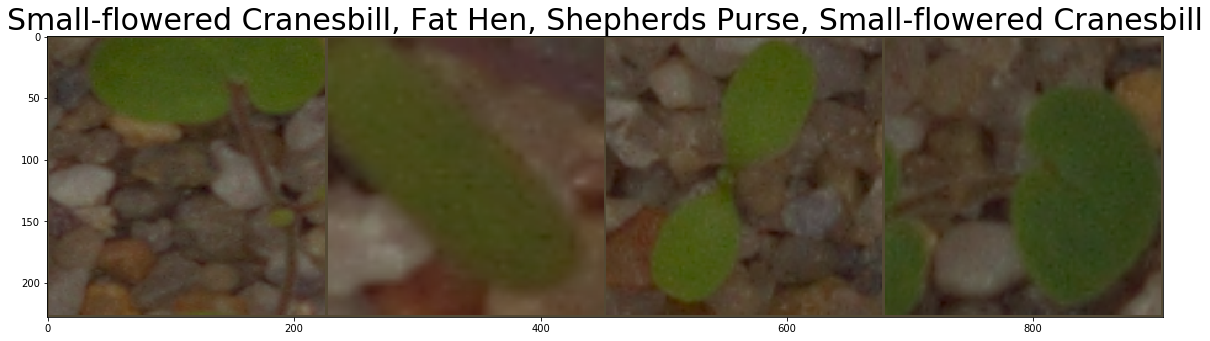

In [7]:
def images_show(dataloader, classes_dict, mean, std):
    """Imshow for Tensor."""
    
    if torch.is_tensor(mean): mean = mean.numpy()
    if torch.is_tensor(std): std = std.numpy()
        
    inputs, classes = next(iter(dataloader))
    
    output = torchvision.utils.make_grid(inputs)
    output = output.numpy().transpose((1, 2, 0))
    output = std * output + mean # Unnormalize
 
    plt.figure(figsize=(20, 10))
    plt.imshow(output)
    plt.title(', '.join([classes_dict[class_] for class_ in classes]), fontsize=30)
    
images_show(train_dl, classes_dict, mean, std)

## Neural network
### Training function

In [11]:
def train_model(model, dataloaders, dataset_size, criterion, 
                optimizer, scheduler, use_gpu, num_epochs=10):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, conf_matrix_best = 0.0, []
    
    
    for epoch in range(num_epochs):
        print('Epoch %2d/%2d' % (epoch + 1, num_epochs))
        print('-' * 20)
               
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss, running_corrects = 0.0, 0
            pred_tot, labels_tot = [], []

            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                _, predictions = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    # Prepare labels and predictions for confusion matrix 
                    pred_dic = np.array([classes_dict[pred] for pred in predictions])
                    pred_tot = np.concatenate((pred_tot, pred_dic))
                    labels_dic = np.array([classes_dict[lab] for lab in labels.data])
                    labels_tot = np.concatenate((labels_tot, labels_dic))
                    
                running_loss += loss.data[0] * inputs.size(0)              
                running_corrects += torch.sum(predictions == labels.data)
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects / dataset_size[phase]
            
            print('%5s  Loss: %.3f | Acc: %.3f' % (phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                conf_matrix_best = confusion_matrix(pred_tot, labels_tot)
                class_report_best = classification_report(pred_tot, labels_tot)
         
        print('\n')
    
    print('-' * 40)
    
    time_elapsed = time.time() - since
    print('Training complete in %.0fm %.0fs'%( time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: %.3f' % (best_acc))
    print("Best Confusion Matrix:\n")
    print(conf_matrix_best)   
    print("\nClassification report:\n" )
    print(class_report_best) 
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

### Define the neural network

In [12]:
model = models.squeezenet1_1(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Dropout(),
                                 nn.Conv2d(512, len(classes), 1),
                                 nn.ReLU(),
                                 nn.AvgPool2d(13, stride=1))

model.num_classes = len(classes)

if use_gpu: model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loaders = {'train': train_dl, 'valid': valid_dl}

### Training the model

In [13]:
model = train_model(model, loaders, dataset_sizes, criterion, 
                    optimizer, exp_lr_scheduler, use_gpu, num_epochs=1)

Epoch  1/ 1
--------------------
train  Loss: 1.410 | Acc: 0.552
valid  Loss: 1.085 | Acc: 0.623


----------------------------------------
Training complete in 3m 10s
Best val Acc: 0.623
Best Confusion Matrix:

[[ 40   1   0   0  12   3  56   0   3   0   1   0]
 [  0  47   0   0   0   2   0   0   0   0   0   0]
 [  0   6  49   1   2   1   0   0   0   0   1   0]
 [  0   3   0 110   0  12   1   2  16   5   9   0]
 [  1   0   0   0  22   0   1   0   0   0   0   0]
 [  0   0   0   0   2  31   0   0   0   0   0   1]
 [  7   0   0   0   1   0  56   0   0   0   0   0]
 [  0   0   0   0   0   0   0  24   0   0   0   0]
 [  0   0   0   0   0   0   6   0  43   0   1   0]
 [  0  11   2  12   0   0   1   0  47  32  37   0]
 [  0   1   1   0   0   0   0   0   0   2  64   0]
 [  3  13   5   1   3  48   0  14   0   0   0  74]]

Classification report:

                           precision    recall  f1-score   support

              Black-grass       0.78      0.34      0.48       116
               